# Análise dos dados de viagens de táxis de Nova York - dados da NYC

## Bibliotecas

In [0]:
from pyspark.sql.functions import col, avg, round, count
import matplotlib.pyplot as plt

## Parâmetros

In [0]:
# Configuração Inicial
dbutils.widgets.text("analysis_month", "2023-05", "Mês de Análise (YYYY-MM)")

# Obter Parâmetro
analysis_month = dbutils.widgets.get("analysis_month")
year = int(year)  # Convertendo para inteiro
month = int(month)  # Convertendo para inteiro

print(f"Análise para o mês {month}/{year}")

# Conectar à tabela Gold
gold_table = "case_ifood_nyc_taxi.gold_unified_taxi"

Análise para o mês 5/2023


## Análise 1: Média do Valor Total (Yellow Taxis)

In [0]:
# SQL
avg_amount_query = f"""
SELECT 
    ROUND(AVG(total_amount), 2) AS avg_total_amount,
    vehicle_type
FROM {gold_table}
WHERE 
    vehicle_type = 'yellow'
    AND meta_file_year = {year}
    AND meta_file_month = {month}
GROUP BY vehicle_type
"""

display(spark.sql(avg_amount_query))

avg_total_amount,vehicle_type
28.96,yellow


In [0]:
# SQL para todos os meses
avg_amount_query_all_months = f"""
SELECT 
    vehicle_type,
    meta_file_year AS year,
    meta_file_month AS month,
    ROUND(AVG(total_amount), 2) AS avg_total_amount
FROM {gold_table}
WHERE 
    vehicle_type IN ('yellow', 'green')
GROUP BY 
    vehicle_type, 
    meta_file_year, 
    meta_file_month
ORDER BY 
    vehicle_type,
    year,
    month
"""

# Executar a consulta e exibir os resultados
df_avg_all_months = spark.sql(avg_amount_query_all_months)
display(df_avg_all_months)

vehicle_type,year,month,avg_total_amount
green,2023,1,21.79
green,2023,2,21.88
green,2023,3,22.29
green,2023,4,23.08
green,2023,5,23.82
yellow,2023,1,27.02
yellow,2023,2,26.9
yellow,2023,3,27.8
yellow,2023,4,28.27
yellow,2023,5,28.96


## Análise 2: Média de Passageiros por Hora (Todos os Táxis - Maio)

In [0]:
from pyspark.sql.functions import col, avg, round, count

# Código corrigido com parênteses adequados
passengers_by_hour = (spark.table(gold_table)
    .filter(
        (col("meta_file_year") == year) & 
        (col("meta_file_month") == month)
    )
    .groupBy("pickup_hour")
    .agg(
        round(avg("passenger_count"), 2).alias("avg_passengers"),
        count("*").alias("total_trips")
    )
    .orderBy("pickup_hour"))

display(passengers_by_hour)

pickup_hour,avg_passengers,total_trips
0,1.42,95270
1,1.43,62151
2,1.45,40299
3,1.44,26597
4,1.4,18432
5,1.28,20754
6,1.26,50692
7,1.27,102263
8,1.29,138841
9,1.3,153788


## Exra 1 - Gráfico de passageiro por hora

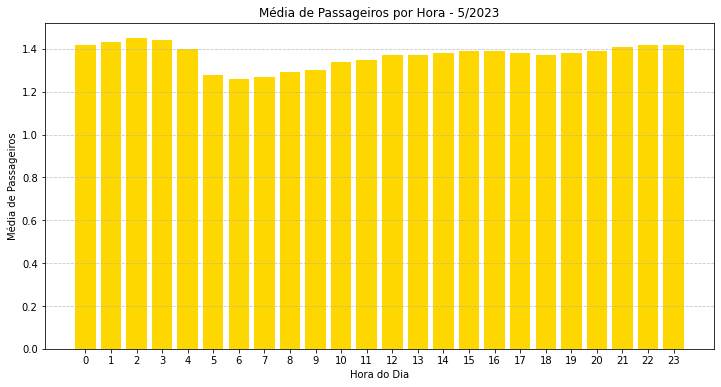

In [0]:
# Gráfico de Média de Passageiros por Hora
df = passengers_by_hour.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df['pickup_hour'], df['avg_passengers'], color='#FFD700')
plt.title(f'Média de Passageiros por Hora - {month}/{year}')
plt.xlabel('Hora do Dia')
plt.ylabel('Média de Passageiros')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Exra 2 - Cálculo do Tempo Médio de Duração da Corrida

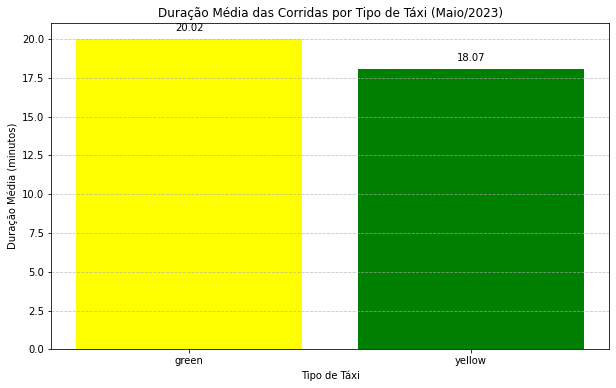

vehicle_type,avg_duration,total_trips,avg_amount
green,20.02,69174,23.82
yellow,18.07,3513649,28.96


In [0]:
duration_stats = (spark.table("case_ifood_nyc_taxi.gold_unified_taxi")
    .filter(
        (col("meta_file_year") == year) &
        (col("meta_file_month") == month)
    )
    .groupBy("vehicle_type")
    .agg(
        round(avg("trip_duration_minutes"), 2).alias("avg_duration"),
        count("*").alias("total_trips"),
        round(avg("total_amount"), 2).alias("avg_amount")
    )
    .orderBy("vehicle_type")
)

# Converter para Pandas para visualização
df = duration_stats.toPandas()

# Criar gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(df['vehicle_type'], df['avg_duration'], color=['yellow', 'green'])
plt.title('Duração Média das Corridas por Tipo de Táxi (Maio/2023)')
plt.xlabel('Tipo de Táxi')
plt.ylabel('Duração Média (minutos)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(df['avg_duration']):
    plt.text(i, value + 0.5, str(value), ha='center')

plt.show()

display(duration_stats)